# Imports

In [3]:
import os
import pandas as pd

In [4]:
#csv_path = '../content/sample_data' # google colab path
csv_path = '../raw_data' # our pc path
cleanfake = pd.read_csv(os.path.join(csv_path, 'clean_data_Fake.csv'))
cleantrue = pd.read_csv(os.path.join(csv_path, 'clean_data_True.csv'))

In [5]:
cleanfake

,text,target
0,donald trump send embarrass new year eve messa...,0
1,drink brag trump staffer start russian collusi...,0
2,sheriff david clarke become internet joke thre...,0
3,trump so ob even obama name cod website image ...,0
4,pope francis call donald trump christmas speec...,0
...,...,...
23476,mcpain john mccain furious iran treat u sailor...,0
23477,justice yahoo settle e mail privacy class acti...,0
23478,sunnistan u ally safe zone plan take territori...,0
23479,blow million al jazeera america finally call q...,0


In [6]:
cleantrue

,text,target
0,budget fight loom republican flip fiscal scrip...,0
1,military accept transgender recruit monday pen...,0
2,senior republican senator let mueller job wash...,0
3,fbi russia probe help australian diplomat tip ...,0
4,trump want postal service charge much amazon s...,0
...,...,...
21412,fully commit nato back new approach afghanista...,0
21413,lexisnexis withdraw two product chinese market...,0
21414,minsk cultural hub become from authority minsk...,0
21415,vatican upbeat possibility pope francis visit ...,0


In [7]:
cleantrue['target'] = 1
cleantrue

,text,target
0,budget fight loom republican flip fiscal scrip...,1
1,military accept transgender recruit monday pen...,1
2,senior republican senator let mueller job wash...,1
3,fbi russia probe help australian diplomat tip ...,1
4,trump want postal service charge much amazon s...,1
...,...,...
21412,fully commit nato back new approach afghanista...,1
21413,lexisnexis withdraw two product chinese market...,1
21414,minsk cultural hub become from authority minsk...,1
21415,vatican upbeat possibility pope francis visit ...,1


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2022-08-25 17:48:49.682158: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-25 17:48:49.791110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 17:48:49.791133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Variables

In [9]:
es = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

In [10]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

2022-08-25 17:48:55.300904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 17:48:55.300967: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 17:48:55.301129: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-0UJ0SON8): /proc/driver/nvidia/version does not exist
2022-08-25 17:48:55.302090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
fulldf = pd.concat ([cleanfake, cleantrue], ignore_index=True)
fulldf = fulldf.sample(n=len(fulldf), ignore_index=True)

In [15]:
fulldf

,text,target
0,uk leader criticize president trump tweet isla...,0
1,obama start work pick supreme court justice am...,1
2,rare behind scene look president trump visit n...,0
3,eric trump remove doubt international business...,0
4,south africa anc want avoid split vote senior ...,1
...,...,...
44893,swedish airport explosive suspect release with...,1
44894,shout poll protester allow shut political rall...,0
44895,yet jill stein file federal lawsuit pennsylvan...,0
44896,break president trump make national security a...,0


# Functions

In [11]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

In [12]:
def initialize_model (model_name, neurons):
    model = Sequential()
    model.add(Embedding(
        input_dim=(len(tokenizer.word_index))+1, # +1 for the 0 padding
        input_length=300, # Max_sentence_length (optional, for model summary)
        output_dim=100,
        mask_zero=True, # Built-in masking layer :)
    ))
    if model_name == 'lstm':
        model.add(LSTM((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'gru':
        model.add(GRU((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'cnn':
        model.add(Conv1D(neurons, kernel_size=5, activation='tanh'))
        model.add(Flatten())
        model.add(Dense((neurons/2), activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=[binacc, prec, rec]) 
    return model

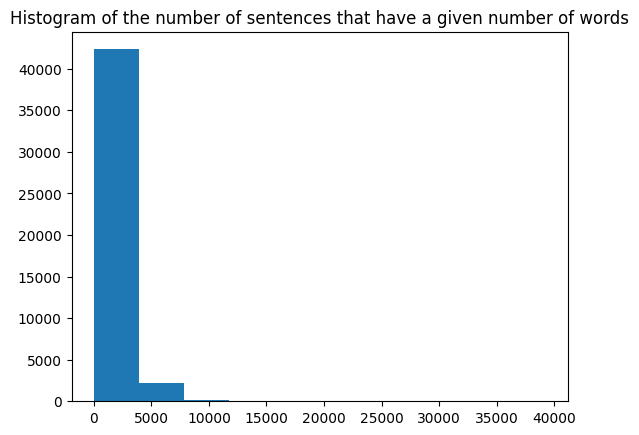

In [20]:
def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(fulldf['text'])

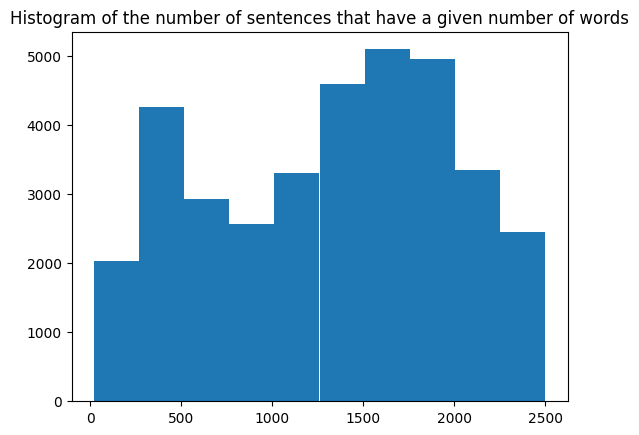

In [17]:
def plot_hist(X):
    len_ = [len(_) for _ in X if len(_) < 2500]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(fulldf['text'])

# Preparing data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(fulldf['text'], fulldf['target'], test_size=0.25)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)

# Testing model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          8807500   
                                                                 
 conv1d (Conv1D)             (None, 296, 12)           6012      
                                                                 
 flatten (Flatten)           (None, 3552)              0         
                                                                 
 dense (Dense)               (None, 6)                 21318     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 8,834,837
Trainable params: 8,834,837
Non-trainable params: 0
_________________________________________________________________
351/351 [==============================] - 1s 

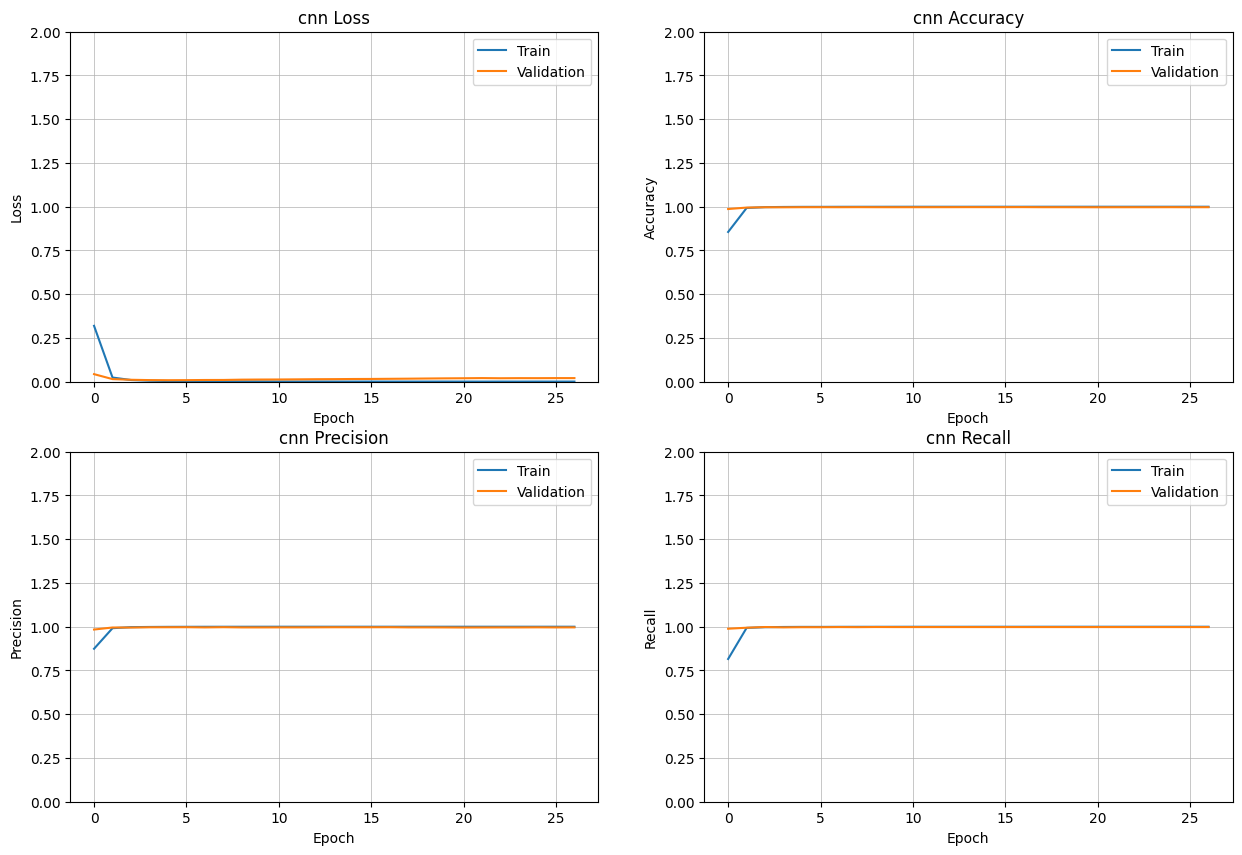

CPU times: user 26min 43s, sys: 2min 14s, total: 28min 57s
Wall time: 6min 51s


In [19]:
%%time
model = compile_model(initialize_model('cnn', 12))
model.summary()
history = model.fit(X_train_token, y_train, 
      epochs=50, 
      batch_size=32,
      validation_split=0.25,
      callbacks=[es],
    verbose = 1, 
    use_multiprocessing=True
      )
model.evaluate(X_test_token, y_test, verbose=1)
plot_loss_accuracy(history, 'cnn')

# Conclusion: now we're talking!